In [36]:
import uproot
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

plt.rc('font', size=18)

In [37]:
dfs = []
for file_path in glob.glob("output/*.root"):
    f = uproot.open(file_path)
    t = f.get("tree")
    dfs.append(t.pandas.df())
    
dfs = pd.concat(dfs)
els_df = dfs[dfs.lepton_id.abs() == 11]
mus_df = dfs[dfs.lepton_id.abs() == 13]

## 1. Sanity Checks

In [38]:
dfs.lepton_id.unique()

array([-13,  11, -11,  13])

In [39]:
np.sum(dfs.is_tight)

1869

In [40]:
np.sum(dfs.is_loose)

23208

In [41]:
np.sum(dfs.light_mother | dfs.heavy_mother | dfs.unmatched)

22939

## 2. Fake rate calculation

### 2.1 Plots

In [161]:
def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    return a * (1.0 - (0.299 * r + 0.587 * g + 0.114 * b))

def bin_text(counts, x_edges, y_edges, axes, cbar, fmt=":g"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2

    xyz = np.c_[
        
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, z), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            ("{"+fmt+"}").format(z),
            color=color,
            ha="center",
            va="center",
            fontsize=8,
            wrap=True,
        )

    return

def fake_rate_2D(df, pt_bin_edges, eta_bin_edges, plot=True, fig=None, axes=None):
    # Collect bin edges
    bin_edges = np.array([pt_bin_edges, eta_bin_edges])
    # Count loose fakes
    loose_counts, _, _ = np.histogram2d(df[df.is_loose].lepton_pt_corr, 
                                        df[df.is_loose].lepton_eta, 
                                        bins=bin_edges)
    # Count tight fakes
    tight_counts, _, _ = np.histogram2d(df[df.is_tight].lepton_pt_corr, 
                                         df[df.is_tight].lepton_eta, 
                                         bins=bin_edges)
    # Divide them
    fake_rate = np.divide(tight_counts.T, loose_counts.T, 
                          where=(loose_counts.T != 0))
    fake_rate[loose_counts.T == 0] = 0
    # Plot
    if plot:
        if not fig or not axes:
            fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
            axes = plt.subplot(111)
        c = axes.pcolorfast(pt_bin_edges, eta_bin_edges, fake_rate)
        cbar = fig.colorbar(c, ax=axes)
        bin_text(fake_rate, pt_bin_edges, eta_bin_edges, axes, cbar, fmt=":0.2f");
        # Format plot
        plt.title(r'$f_{\mu}(p_{T},\eta)$ = $N_{tight}^{\mu}$/$N_{loose}^{\mu}$');
        plt.xlabel(r'$p_{T}$');
        plt.ylabel(r'$\eta$');
    
    return fake_rate

def fake_rate_1D(loose_pts, tight_pts, label="", fmt="rs",
                 fig=None, axes=None):
    if not fig or not axes:
        fig = plt.figure(figsize=(6.4,6.4))
        axes = plt.subplot(111)
    pt_bin_edges = np.array([10,15,20,25,35,50,70,90])
    # Get histogram values
    loose_counts, _ = np.histogram(loose_pts, bins=pt_bin_edges)
    tight_counts, _ = np.histogram(tight_pts, bins=pt_bin_edges)
    fake_rates = np.divide(1.0*tight_counts, loose_counts, 
                           where=(loose_counts != 0))
    bin_widths = pt_bin_edges[1:]-pt_bin_edges[:-1]
    bin_centers = pt_bin_edges[:-1]+0.5*bin_widths
    # Plot error bars
    axes.errorbar(bin_centers, fake_rates, xerr=0.5*bin_widths, fmt=fmt, label=label);
    plt.ylim([0,0.6])
    axes.margins(0) # Remove axis margins
    axes.xaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_minor_locator(AutoMinorLocator())
    
    return bin_centers

def fake_rate_1D_from2D(counts, errors, pt_bin_edges,
                        label="", fmt="rs", fig=None, axes=None):
    """Stolen from Nick Amin: https://github.com/aminnj/yahist"""
    if not fig or not axes:
        fig = plt.figure(figsize=(1.5*6.4,1.5*6.4))
        axes = plt.subplot(111)
    # Get 1D plot by averaging over one axis+
    pt_bin_centers = 0.5*(pt_bin_edges[:-1] + pt_bin_edges[1:])
    pt_bin_widths = pt_bin_edges[1:]-pt_bin_edges[:-1]
    numer = np.divide(counts, errors, where=(errors != 0))**2.
    numer[errors == 0] = 0
    numer = numer.sum(axis=0)
    denom = np.divide(1, errors, where=(errors != 0))**2.
    denom[errors == 0] = 0
    denom = denom.sum(axis=0)
    new_counts = np.divide(numer, denom, where=(denom != 0))
    new_counts[denom == 0] = 0
    new_errors = np.divide(1, denom**0.5, where=(denom**0.5 != 0))
    new_errors[denom**0.5 == 0] = 0
    # Plot new 1D plot
    axes.errorbar(pt_bin_centers, new_counts, xerr=0.5*pt_bin_widths, fmt=fmt, label=label);
    
    return

### 2.2 Fake rate binning

In [109]:
el_pt_bin_edges = np.array([10,15,20,25,35,50,70,90])
el_eta_bin_edges = np.array([0,0.8,1.47,2.5])
el_bin_edges = np.array([el_pt_bin_edges, el_eta_bin_edges])

mu_pt_bin_edges = np.array([10,15,20,25,35,50,70,90])
mu_eta_bin_edges = np.array([0,1.2,2.1,2.4])
mu_bin_edges = np.array([mu_pt_bin_edges, mu_eta_bin_edges])

### 2.3 Electrons

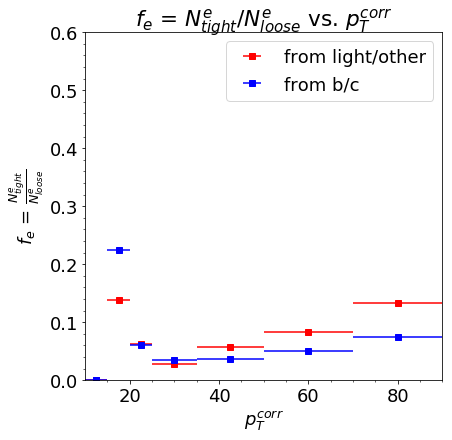

In [143]:
fig = plt.figure(figsize=(6.4,6.4))
axes = plt.subplot(111)

fake_rate_1D(els_df[els_df.is_loose & (els_df.light_mother | els_df.unmatched)].lepton_pt_corr, 
             els_df[els_df.is_tight & (els_df.light_mother | els_df.unmatched)].lepton_pt_corr,
             fig=fig, axes=axes, label="from light/other")

fake_rate_1D(els_df[els_df.is_loose & els_df.heavy_mother].lepton_pt_corr, 
             els_df[els_df.is_tight & els_df.heavy_mother].lepton_pt_corr,
             fig=fig, axes=axes, fmt="bs", label="from b/c")

plt.title(r'$f_{e}$ = $N_{tight}^{e}$/$N_{loose}^{e}$ vs. $p_{T}^{corr}$');
plt.ylabel(r'$f_{e}$ = $\frac{N_{tight}^{e}}{N_{loose}^{e}}$');
plt.xlabel(r'$p_{T}^{corr}$');

plt.legend();

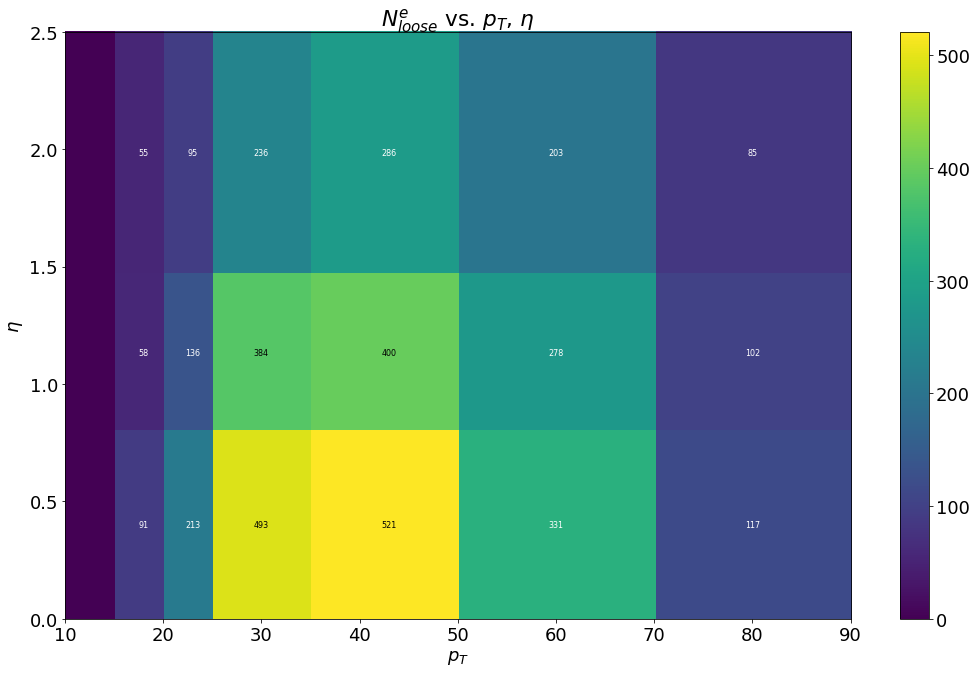

In [59]:
fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)


loose_el_counts, _, _, _ = plt.hist2d(els_df[els_df.is_loose].lepton_pt_corr, 
                                      els_df[els_df.is_loose].lepton_eta, 
                                      bins=el_bin_edges)
cbar = plt.colorbar()
bin_text(loose_el_counts.T, el_pt_bin_edges, el_eta_bin_edges, axes, cbar)

plt.title(r'$N_{loose}^{e}$ vs. $p_{T}$, $\eta$');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

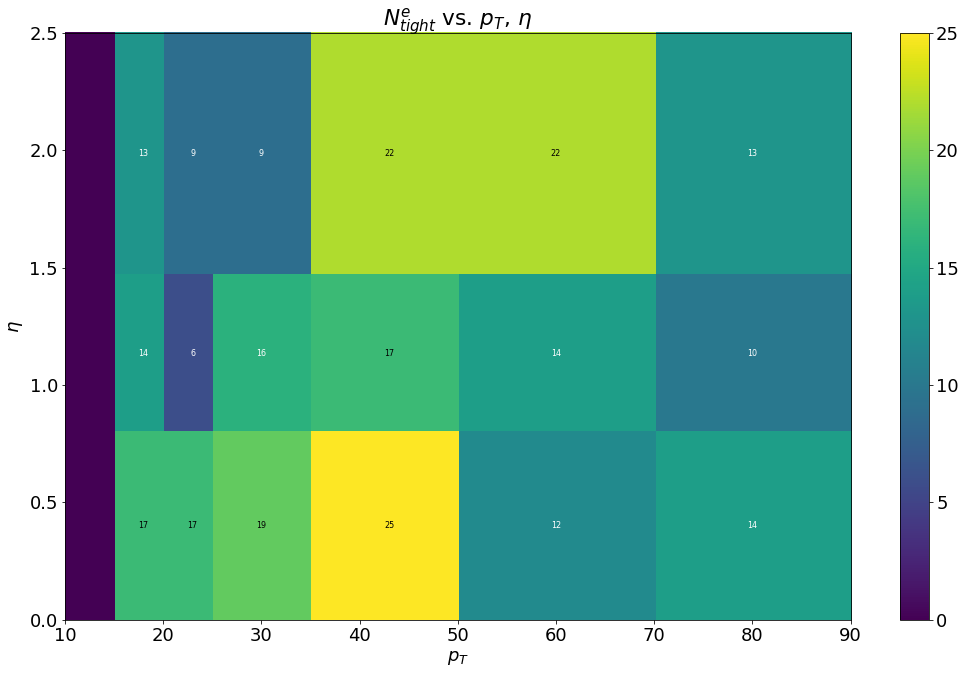

In [60]:
fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)

tight_el_counts, _, _, _ = plt.hist2d(els_df[els_df.is_tight].lepton_pt_corr, 
                                      els_df[els_df.is_tight].lepton_eta, 
                                      bins=el_bin_edges)
cbar = plt.colorbar();
bin_text(tight_el_counts.T, el_pt_bin_edges, el_eta_bin_edges, axes, cbar)

plt.title(r'$N_{tight}^{e}$ vs. $p_{T}$, $\eta$');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

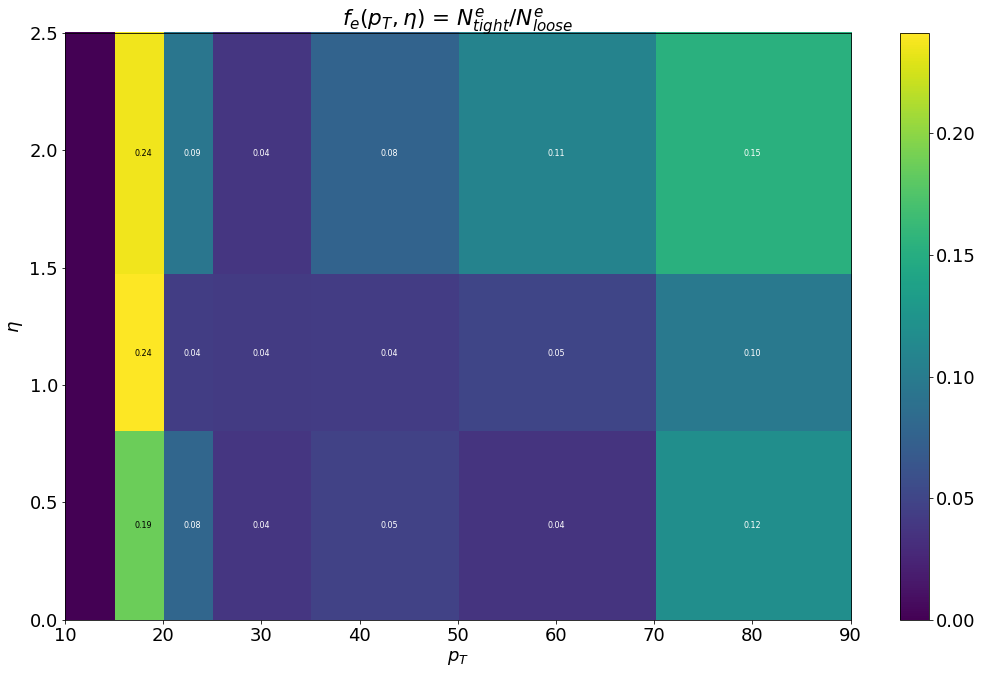

In [61]:
fake_el_rate = np.divide(tight_el_counts.T, loose_el_counts.T, where=(loose_el_counts.T != 0))
fake_el_rate[loose_el_counts.T == 0] = 0

fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)
c = axes.pcolorfast(el_pt_bin_edges, el_eta_bin_edges, fake_el_rate)
cbar = fig.colorbar(c, ax=axes)
bin_text(fake_el_rate, el_pt_bin_edges, el_eta_bin_edges, axes, cbar, fmt=":0.2f");

plt.title(r'$f_{e}(p_{T},\eta)$ = $N_{tight}^{e}$/$N_{loose}^{e}$');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

### 2.4 Muons

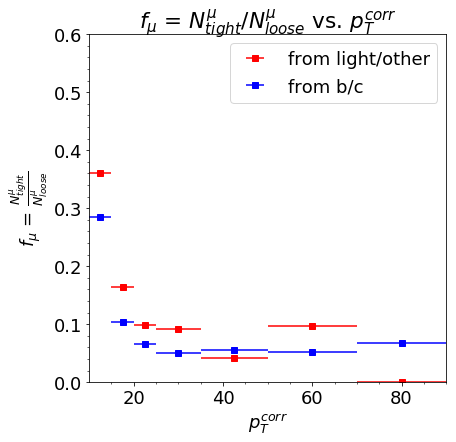

In [144]:
fig = plt.figure(figsize=(6.4,6.4))
axes = plt.subplot(111)

fake_rate_1D(mus_df[mus_df.is_loose & (mus_df.light_mother | mus_df.unmatched)].lepton_pt_corr, 
             mus_df[mus_df.is_tight & (mus_df.light_mother | mus_df.unmatched)].lepton_pt_corr,
             fig=fig, axes=axes, label="from light/other")

fake_rate_1D(mus_df[mus_df.is_loose & mus_df.heavy_mother].lepton_pt_corr, 
             mus_df[mus_df.is_tight & mus_df.heavy_mother].lepton_pt_corr,
             fig=fig, axes=axes, fmt="bs", label="from b/c")

plt.title(r'$f_{\mu}$ = $N_{tight}^{\mu}$/$N_{loose}^{\mu}$ vs. $p_{T}^{corr}$');
plt.ylabel(r'$f_{\mu}$ = $\frac{N_{tight}^{\mu}}{N_{loose}^{\mu}}$');
plt.xlabel(r'$p_{T}^{corr}$');

plt.legend();

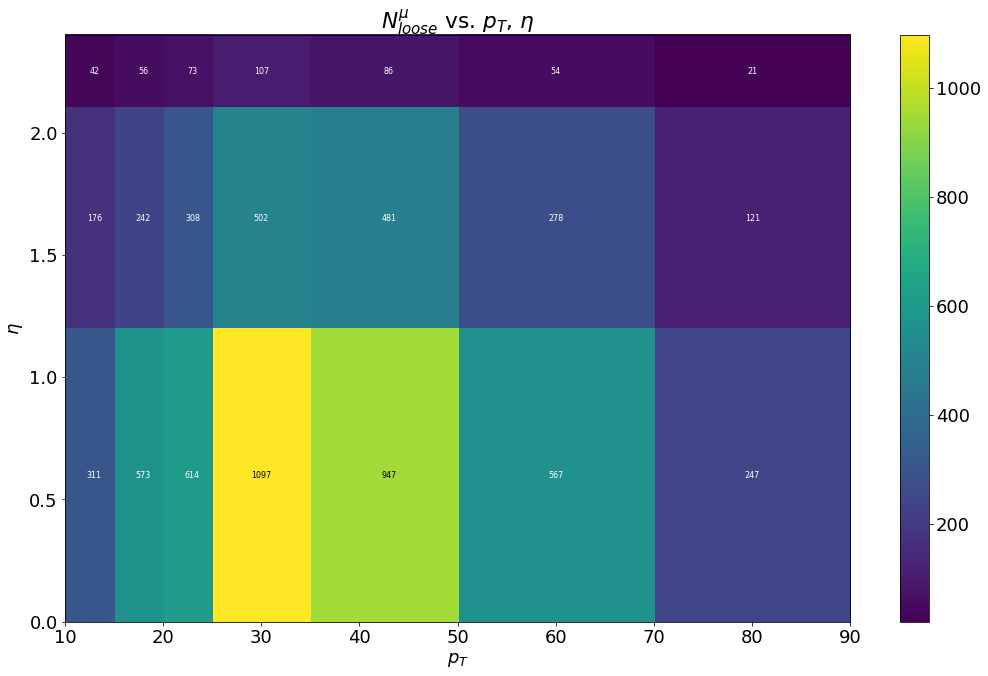

In [62]:
fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)


loose_mu_counts, _, _, _ = plt.hist2d(mus_df[mus_df.is_loose].lepton_pt_corr, 
                                      mus_df[mus_df.is_loose].lepton_eta, 
                                      bins=mu_bin_edges)
cbar = plt.colorbar()
bin_text(loose_mu_counts.T, mu_pt_bin_edges, mu_eta_bin_edges, axes, cbar)

plt.title(r'$N_{loose}^{\mu}$ vs. $p_{T}$, $\eta$');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

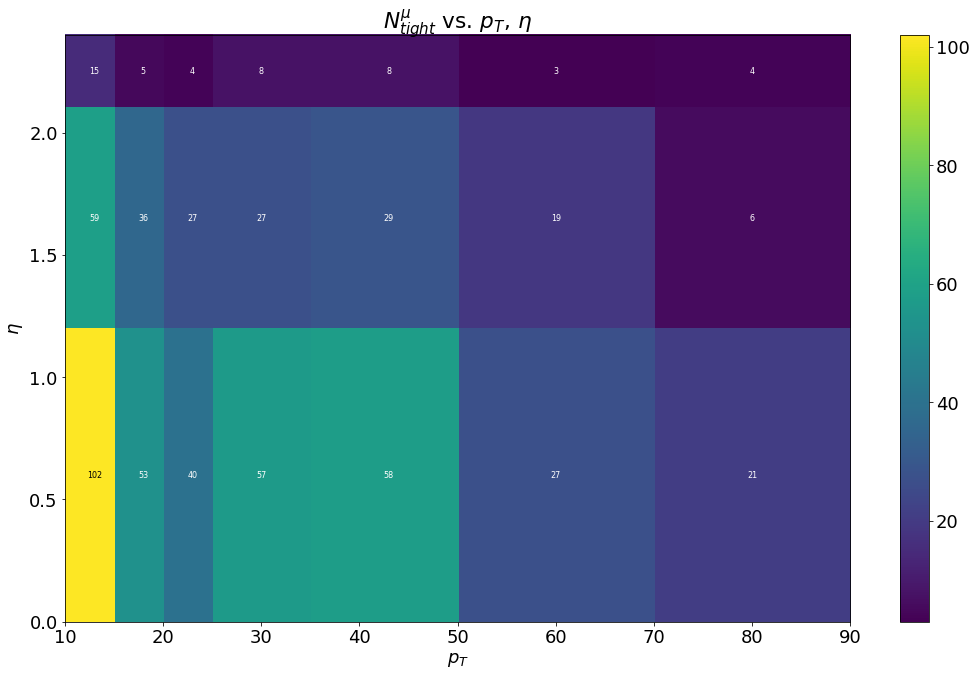

In [63]:
fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)

tight_mu_counts, _, _, _ = plt.hist2d(mus_df[mus_df.is_tight].lepton_pt_corr, 
                                      mus_df[mus_df.is_tight].lepton_eta, 
                                      bins=mu_bin_edges)
cbar = plt.colorbar();
bin_text(tight_mu_counts.T, mu_pt_bin_edges, mu_eta_bin_edges, axes, cbar)

plt.title(r'$N_{tight}^{\mu}$ vs. $p_{T}$, $\eta$');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

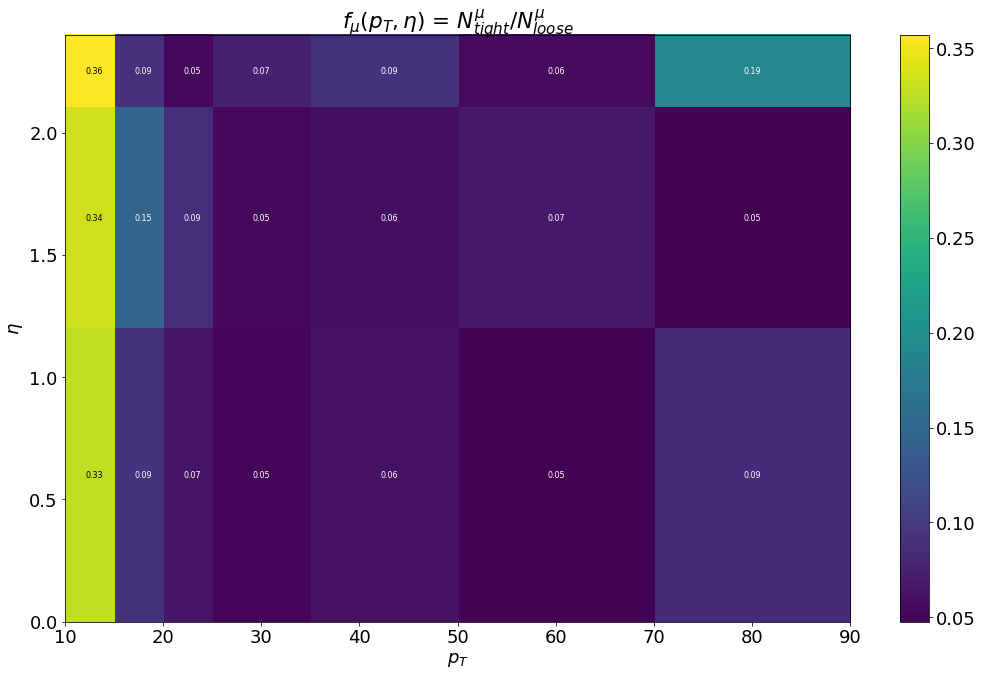

In [64]:
fake_mu_rate = np.divide(tight_mu_counts.T, loose_mu_counts.T, where=(loose_mu_counts.T != 0))
fake_mu_rate[loose_mu_counts.T == 0] = 0

fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)
c = axes.pcolorfast(mu_pt_bin_edges, mu_eta_bin_edges, fake_mu_rate)
cbar = fig.colorbar(c, ax=axes)
bin_text(fake_mu_rate, mu_pt_bin_edges, mu_eta_bin_edges, axes, cbar, fmt=":0.2f");

plt.title(r'$f_{\mu}(p_{T},\eta)$ = $N_{tight}^{\mu}$/$N_{loose}^{\mu}$');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

## 3. NanoAOD vs. MiniAOD

### 3.1 Electrons

```cpp
float electronQCDMCFakeRate(float pt, float eta) {
   if (pt>=10 && pt<15 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0000; // +-0.0%;
   if (pt>=10 && pt<15 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0000; // +-0.0%;
   if (pt>=10 && pt<15 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0000; // +-0.0%;
   if (pt>=15 && pt<20 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.2133; // +-5.1%;
   if (pt>=15 && pt<20 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.2425; // +-5.8%;
   if (pt>=15 && pt<20 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.2442; // +-7.2%;
   if (pt>=20 && pt<25 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0548; // +-9.2%;
   if (pt>=20 && pt<25 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0803; // +-10.5%;
   if (pt>=20 && pt<25 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0752; // +-11.2%;
   if (pt>=25 && pt<35 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0309; // +-9.9%;
   if (pt>=25 && pt<35 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0414; // +-11.9%;
   if (pt>=25 && pt<35 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0563; // +-12.0%;
   if (pt>=35 && pt<50 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0509; // +-18.3%;
   if (pt>=35 && pt<50 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0457; // +-19.5%;
   if (pt>=35 && pt<50 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0585; // +-17.0%;
   if (pt>=50 && pt<70 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0458; // +-31.5%;
   if (pt>=50 && pt<70 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0933; // +-26.8%;
   if (pt>=50 && pt<70 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0824; // +-23.0%;
   if (pt>=70 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.1757; // +-18.4%;
   if (pt>=70 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.1353; // +-22.0%;
   if (pt>=70 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.2190; // +-14.6%;
   return 0.;
}

float electronQCDMCFakeRateError(float pt, float eta) {
   if (pt>=10 && pt<15 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0000;
   if (pt>=10 && pt<15 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0000;
   if (pt>=10 && pt<15 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0000;
   if (pt>=15 && pt<20 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0108;
   if (pt>=15 && pt<20 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0140;
   if (pt>=15 && pt<20 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0176;
   if (pt>=20 && pt<25 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0050;
   if (pt>=20 && pt<25 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0085;
   if (pt>=20 && pt<25 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0084;
   if (pt>=25 && pt<35 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0031;
   if (pt>=25 && pt<35 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0049;
   if (pt>=25 && pt<35 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0067;
   if (pt>=35 && pt<50 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0093;
   if (pt>=35 && pt<50 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0089;
   if (pt>=35 && pt<50 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0099;
   if (pt>=50 && pt<70 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0144;
   if (pt>=50 && pt<70 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0250;
   if (pt>=50 && pt<70 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0190;
   if (pt>=70 && fabs(eta)>=0.000 && fabs(eta)<0.800) return 0.0324;
   if (pt>=70 && fabs(eta)>=0.800 && fabs(eta)<1.479) return 0.0298;
   if (pt>=70 && fabs(eta)>=1.479 && fabs(eta)<2.500) return 0.0319;
   return 0.;
}
```

In [52]:
electronQCDMCFakeRate = np.array([
    # 10<=pt<15 # 15<=pt<20 # 20<=pt<25 # 25<=pt<35 # 35<=pt<50 # 50<=pt<70 # 70<=pt<90
    [ 0.0000000 , 0.2133000 , 0.0548000 , 0.0309000 , 0.0509000 , 0.0458000 , 0.1757000 ], # 0.0<=eta<0.8
    [ 0.0000000 , 0.2425000 , 0.0803000 , 0.0414000 , 0.0457000 , 0.0933000 , 0.1353000 ], # 0.8<=eta<1.47 9 
    [ 0.0000000 , 0.2442000 , 0.0752000 , 0.0563000 , 0.0585000 , 0.0824000 , 0.2190000 ], # 1.479<=eta<2.5
])

electronQCDMCFakeRateError = np.array([
    # 10<=pt<15 # 15<=pt<20 # 20<=pt<25 # 25<=pt<35 # 35<=pt<50 # 50<=pt<70 # 70<=pt<90
    [ 0.0000000 , 0.1080000 , 0.0050000 , 0.0031000 , 0.0093000 , 0.0144000 , 0.0324000 ], # 0.0<=eta<0.8
    [ 0.0000000 , 0.1400000 , 0.0085000 , 0.0049000 , 0.0089000 , 0.0250000 , 0.0298000 ], # 0.8<=eta<1.47 9 
    [ 0.0000000 , 0.1760000 , 0.0084000 , 0.0067000 , 0.0099000 , 0.0190000 , 0.0319000 ], # 1.479<=eta<2.5
])

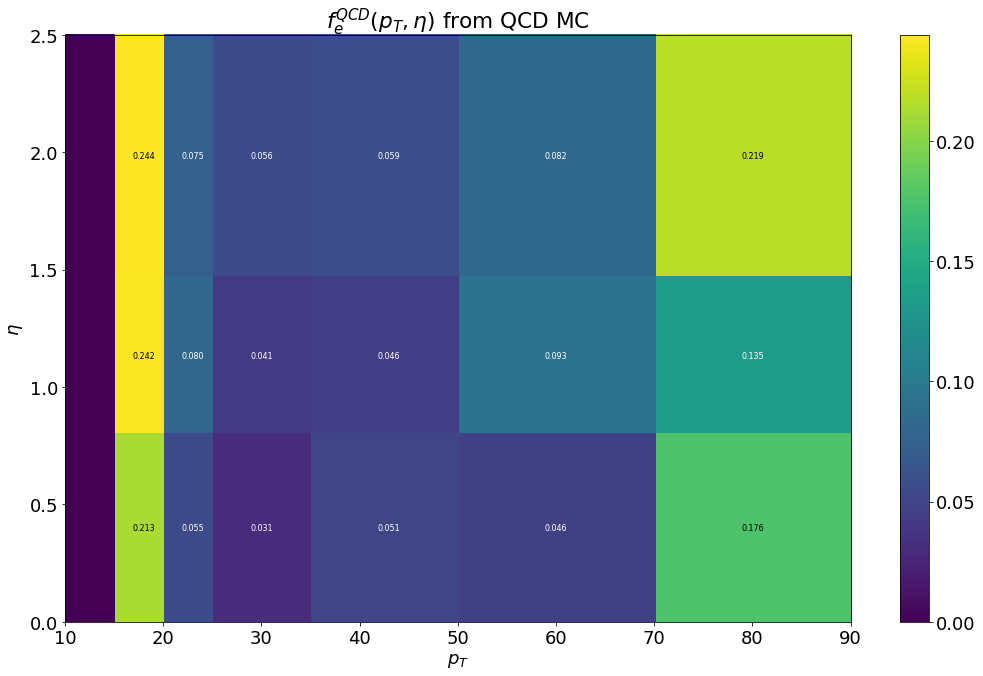

In [73]:
electronQCDMCPtBinEdges = np.array([10,15,20,25,35,50,70,90])
electronQCDMCEtaBinEdges = np.array([0,0.8,1.47,2.5])

fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)
c = axes.pcolorfast(electronQCDMCPtBinEdges, electronQCDMCEtaBinEdges, electronQCDMCFakeRate)
cbar = fig.colorbar(c, ax=axes)
bin_text(electronQCDMCFakeRate, electronQCDMCPtBinEdges, electronQCDMCEtaBinEdges, axes, cbar, fmt=":0.3f");

plt.title(r'$f_{e}^{QCD}(p_{T},\eta)$ from QCD MC');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

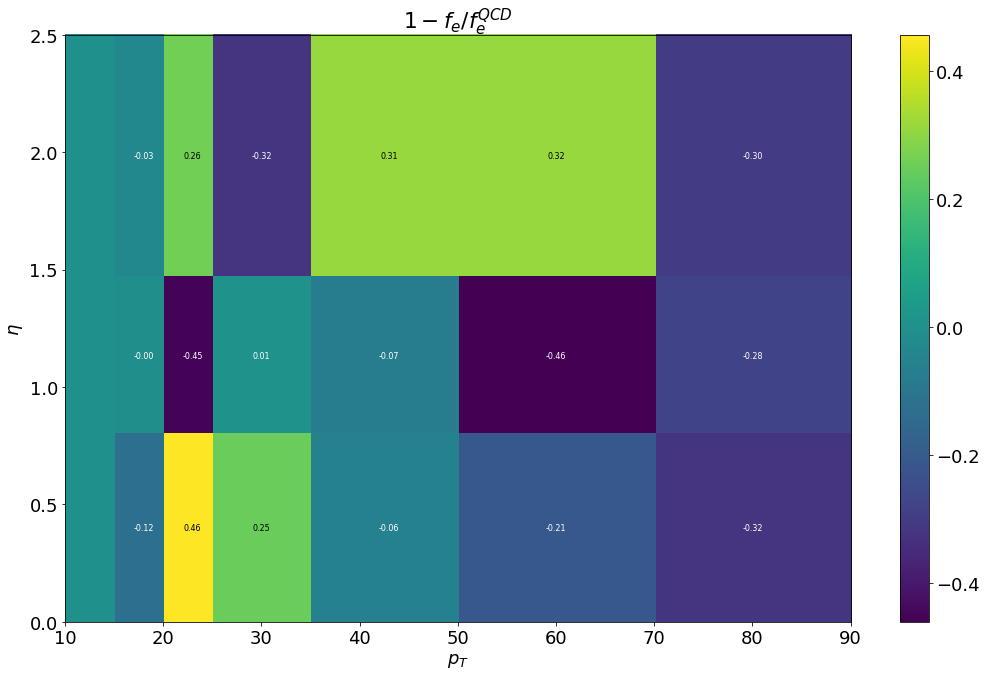

In [76]:
el_FR_comparison = np.divide(fake_el_rate, electronQCDMCFakeRate, where=(electronQCDMCFakeRate != 0))
el_FR_comparison -= 1
el_FR_comparison[electronQCDMCFakeRate == 0] = 0

fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)
c = axes.pcolorfast(el_pt_bin_edges, el_eta_bin_edges, el_FR_comparison)
cbar = fig.colorbar(c, ax=axes)
bin_text(el_FR_comparison, el_pt_bin_edges, el_eta_bin_edges, axes, cbar, fmt=":0.2f");

plt.title(r'$1-f_{e}/f_{e}^{QCD}$');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

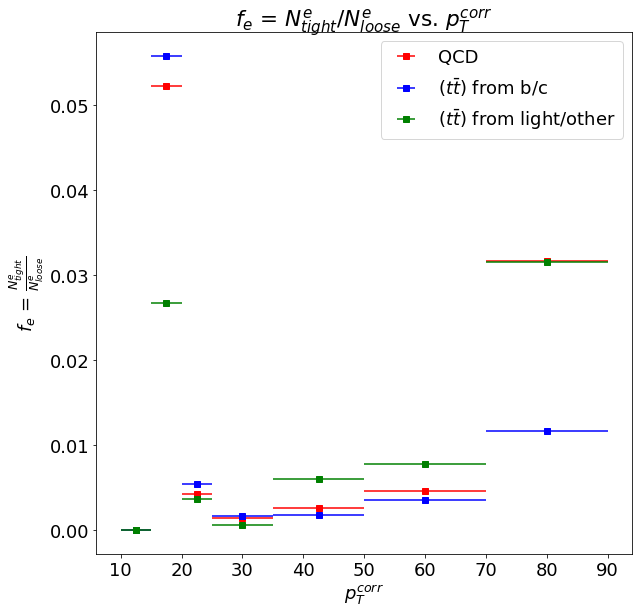

In [167]:
fig = plt.figure(figsize=(1.5*6.4,1.5*6.4))
axes = plt.subplot(111)

fake_rate_1D_from2D(electronQCDMCFakeRate, electronQCDMCFakeRateError, 
                    el_pt_bin_edges, label="QCD", fig=fig, axes=axes)

el_FR_heavy_mothers = fake_rate_2D(els_df[els_df.heavy_mother], 
                                   el_pt_bin_edges, 
                                   el_eta_bin_edges, 
                                   plot=False)

fake_rate_1D_from2D(el_FR_heavy_mothers, np.ones(el_FR_heavy_mothers.shape), 
                    el_pt_bin_edges, label=r"($t\bar{t}$) from b/c", fmt="bs", fig=fig, axes=axes)

el_FR_light_mothers = fake_rate_2D(els_df[els_df.light_mother | els_df.unmatched], 
                                   el_pt_bin_edges, 
                                   el_eta_bin_edges, 
                                   plot=False)

fake_rate_1D_from2D(el_FR_light_mothers, np.ones(el_FR_light_mothers.shape), 
                    el_pt_bin_edges, label=r"($t\bar{t}$) from light/other",
                    fmt="gs", fig=fig, axes=axes)

plt.title(r'$f_{e}$ = $N_{tight}^{e}$/$N_{loose}^{e}$ vs. $p_{T}^{corr}$');
plt.ylabel(r'$f_{e}$ = $\frac{N_{tight}^{e}}{N_{loose}^{e}}$');
plt.xlabel(r'$p_{T}^{corr}$');

plt.legend();

### 3.2 Muons

```cpp
float muonQCDMCFakeRate(float pt, float eta) {
   if (pt>=10 && pt<15 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.2950; // +-1.9%;
   if (pt>=10 && pt<15 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.3308; // +-2.3%;
   if (pt>=10 && pt<15 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.3517; // +-4.4%;
   if (pt>=15 && pt<20 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0776; // +-4.0%;
   if (pt>=15 && pt<20 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0893; // +-4.8%;
   if (pt>=15 && pt<20 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0836; // +-9.2%;
   if (pt>=20 && pt<25 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0505; // +-5.5%;
   if (pt>=20 && pt<25 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0512; // +-6.7%;
   if (pt>=20 && pt<25 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0398; // +-13.6%;
   if (pt>=25 && pt<35 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0399; // +-5.8%;
   if (pt>=25 && pt<35 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0370; // +-7.7%;
   if (pt>=25 && pt<35 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0374; // +-13.1%;
   if (pt>=35 && pt<50 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0421; // +-7.7%;
   if (pt>=35 && pt<50 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0338; // +-9.2%;
   if (pt>=35 && pt<50 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0456; // +-17.5%;
   if (pt>=50 && pt<70 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0405; // +-11.5%;
   if (pt>=50 && pt<70 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0402; // +-15.6%;
   if (pt>=50 && pt<70 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0461; // +-21.0%;
   if (pt>=70 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0473; // +-13.2%;
   if (pt>=70 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0307; // +-19.1%;
   if (pt>=70 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0776; // +-34.5%;
   return 0.;
}

float muonQCDMCFakeRateError(float pt, float eta) {
   if (pt>=10 && pt<15 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0057;
   if (pt>=10 && pt<15 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0076;
   if (pt>=10 && pt<15 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0153;
   if (pt>=15 && pt<20 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0031;
   if (pt>=15 && pt<20 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0043;
   if (pt>=15 && pt<20 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0077;
   if (pt>=20 && pt<25 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0028;
   if (pt>=20 && pt<25 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0034;
   if (pt>=20 && pt<25 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0054;
   if (pt>=25 && pt<35 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0023;
   if (pt>=25 && pt<35 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0029;
   if (pt>=25 && pt<35 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0049;
   if (pt>=35 && pt<50 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0032;
   if (pt>=35 && pt<50 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0031;
   if (pt>=35 && pt<50 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0080;
   if (pt>=50 && pt<70 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0047;
   if (pt>=50 && pt<70 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0063;
   if (pt>=50 && pt<70 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0097;
   if (pt>=70 && fabs(eta)>=0.000 && fabs(eta)<1.200) return 0.0063;
   if (pt>=70 && fabs(eta)>=1.200 && fabs(eta)<2.100) return 0.0059;
   if (pt>=70 && fabs(eta)>=2.100 && fabs(eta)<2.400) return 0.0268;
   return 0.;
}
```

In [55]:
muonQCDMCFakeRate = np.array([
    # 10<=pt<15 # 15<=pt<20 # 20<=pt<25 # 25<=pt<35 # 35<=pt<50 # 50<=pt<70 # 70<=pt<90 
    [ 0.2950000 , 0.0776000 , 0.0505000 , 0.0399000 , 0.0421000 , 0.0405000 , 0.0473000 ], # 0.0<=eta<1.2
    [ 0.3308000 , 0.0893000 , 0.0512000 , 0.0370000 , 0.0338000 , 0.0402000 , 0.0307000 ], # 1.2<=eta<2.1
    [ 0.3517000 , 0.0836000 , 0.0398000 , 0.0374000 , 0.0456000 , 0.0461000 , 0.0776000 ], # 2.1<=eta<2.4
])

muonQCDMCFakeRateError = np.array([
    # 10<=pt<15 # 15<=pt<20 # 20<=pt<25 # 25<=pt<35 # 35<=pt<50 # 50<=pt<70 # 70<=pt<90 
    [ 0.0057000 , 0.0031000 , 0.0028000 , 0.0023000 , 0.0032000 , 0.0047000 , 0.0063000 ], # 0.0<=eta<1.2
    [ 0.0076000 , 0.0043000 , 0.0034000 , 0.0029000 , 0.0031000 , 0.0063000 , 0.0059000 ], # 1.2<=eta<2.1
    [ 0.0153000 , 0.0077000 , 0.0054000 , 0.0049000 , 0.0080000 , 0.0097000 , 0.0268000 ], # 2.1<=eta<2.4
])

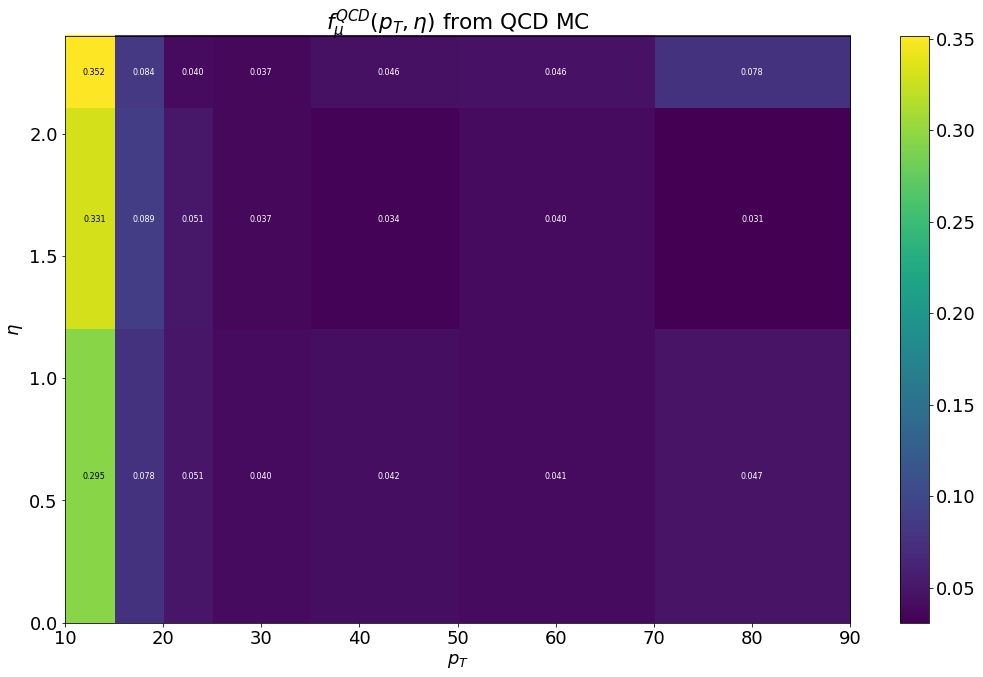

In [71]:
muonQCDMCPtBinEdges = np.array([10,15,20,25,35,50,70,90])
muonQCDMCEtaBinEdges = np.array([0,1.2,2.1,2.4])

fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)
c = axes.pcolorfast(muonQCDMCPtBinEdges, muonQCDMCEtaBinEdges, muonQCDMCFakeRate)
cbar = fig.colorbar(c, ax=axes)
bin_text(muonQCDMCFakeRate, muonQCDMCPtBinEdges, muonQCDMCEtaBinEdges, axes, cbar, fmt=":0.3f");

plt.title(r'$f_{\mu}^{QCD}(p_{T},\eta)$ from QCD MC');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

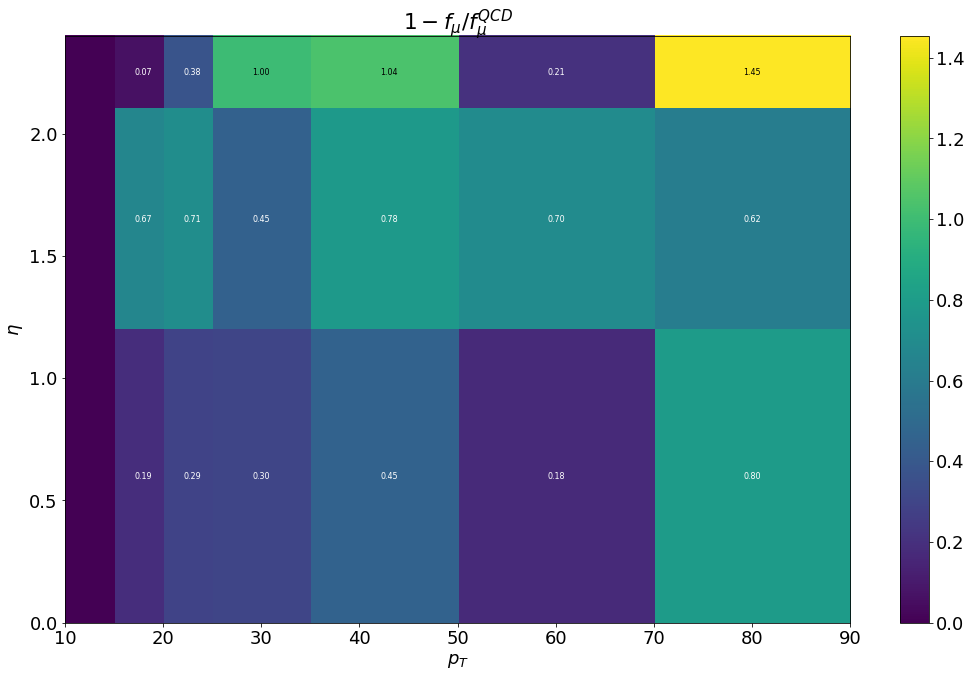

In [78]:
mu_FR_comparison = np.divide(fake_mu_rate, muonQCDMCFakeRate, where=(muonQCDMCFakeRate != 0))
mu_FR_comparison -= 1
mu_FR_comparison[electronQCDMCFakeRate == 0] = 0

fig = plt.figure(figsize=(6.4*2.75,4.8*2.25))
axes = plt.subplot(111)
c = axes.pcolorfast(mu_pt_bin_edges, mu_eta_bin_edges, mu_FR_comparison)
cbar = fig.colorbar(c, ax=axes)
bin_text(mu_FR_comparison, mu_pt_bin_edges, mu_eta_bin_edges, axes, cbar, fmt=":0.2f");

plt.title(r'$1-f_{\mu}/f_{\mu}^{QCD}$');
plt.xlabel(r'$p_{T}$');
plt.ylabel(r'$\eta$');

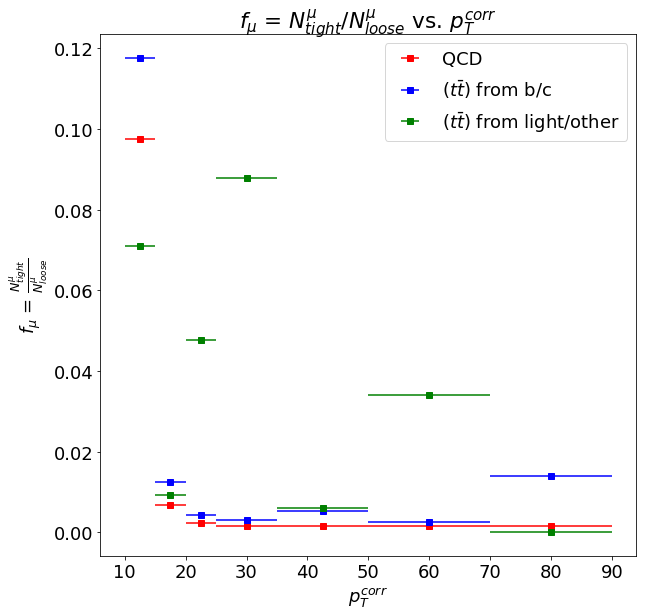

In [168]:
fig = plt.figure(figsize=(1.5*6.4,1.5*6.4))
axes = plt.subplot(111)

fake_rate_1D_from2D(muonQCDMCFakeRate, muonQCDMCFakeRateError, 
                    mu_pt_bin_edges, label="QCD", fig=fig, axes=axes)

mu_FR_heavy_mothers = fake_rate_2D(mus_df[mus_df.heavy_mother], 
                                   mu_pt_bin_edges, 
                                   mu_eta_bin_edges, 
                                   plot=False)

fake_rate_1D_from2D(mu_FR_heavy_mothers, np.ones(mu_FR_heavy_mothers.shape), 
                    mu_pt_bin_edges, label=r"($t\bar{t}$) from b/c", fmt="bs", fig=fig, axes=axes)

mu_FR_light_mothers = fake_rate_2D(mus_df[mus_df.light_mother | mus_df.unmatched], 
                                   mu_pt_bin_edges, 
                                   mu_eta_bin_edges, 
                                   plot=False)

fake_rate_1D_from2D(mu_FR_light_mothers, np.ones(mu_FR_light_mothers.shape), 
                    mu_pt_bin_edges, label=r"($t\bar{t}$) from light/other",
                    fmt="gs", fig=fig, axes=axes)

plt.title(r'$f_{\mu}$ = $N_{tight}^{\mu}$/$N_{loose}^{\mu}$ vs. $p_{T}^{corr}$');
plt.ylabel(r'$f_{\mu}$ = $\frac{N_{tight}^{\mu}}{N_{loose}^{\mu}}$');
plt.xlabel(r'$p_{T}^{corr}$');

plt.legend();